_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 4

In this notebook you will work with preprocessed 2 photon calcium recordings, that have already been converted into spike counts for a population of cells from the Macaque V1. During the experiment the animal has been presented with several drifting grating stimuli, in response to which the neural activity was recorded. In this exercise sheet we will study how you can visualize the activity of multiple neural spike trains and assess whether a neuron is selective to a specific stimulus type.

Download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. We recommend you to use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computations. See [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) on how to do this. Of course, converting the data into classical numpy arrays is also valid.

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

import itertools
import logging

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-05-18 15:48:49Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.17
IPython version      : 8.36.0

sklearn: 1.6.1

matplotlib: 3.10.1
pandas    : 2.2.3
numpy     : 2.2.5
logging   : 0.5.1.2
scipy     : 1.15.2
seaborn   : 0.13.2

Watermark: 2.5.0



In [150]:
# %%
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.info("Starting the script...")


# --- Add these lines to suppress Matplotlib's DEBUG messages ---
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)  # Or logging.INFO, logging.ERROR
# You can also target specific noisy submodules if needed:
# logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)
# logging.getLogger('matplotlib.pyplot').setLevel(logging.WARNING)
# --- End of added lines ---

INFO:__main__:Starting the script...


In [151]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [152]:
spikes = pd.read_csv("../data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("../data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [153]:
# you may add computations as specified above
spikes["Dir"] = np.nan
spikes["relTime"] = np.nan
spikes["Trial"] = np.nan
spikes["stimPeriod"] = np.nan

dirs = np.unique(stims["Dir"])
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    trialcounter[dirs == row["Dir"]] += 1

    i0 = spikes["SpikeTimes"] > row["StimOnset"]
    i1 = spikes["SpikeTimes"] < row["StimOffset"]

    select = i0.values & i1.values

    spikes.loc[select, "Dir"] = row["Dir"]
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][0]
    spikes.loc[select, "relTime"] = spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    spikes.loc[select, "stimPeriod"] = True

spikes = spikes.dropna()

C:\Users\andre\AppData\Local\Temp\ipykernel_16000\4012369867.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spikes.loc[select, "stimPeriod"] = True


In [154]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


In [155]:
stims.head()

,StimOnset,Dir,StimOffset
0,15570,270.0,17570.0
1,19022,45.0,21022.0
2,22592,112.5,24592.0
3,26095,225.0,28095.0
4,29431,180.0,31431.0


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 3 pts*


In [156]:
def plotRaster(spikes: pd.DataFrame, neuron: int):
    """plot spike rasters for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------
    df = spikes[(spikes["Neuron"] == neuron) & (spikes["stimPeriod"])]
    directions = np.sort(df["Dir"].unique())

    fig, ax = plt.subplots(figsize=(8, 4))
    y = 0
    yticks, ylabels = [], []

    for d in directions:
        sub = df[df["Dir"] == d]
        trials = np.sort(sub["Trial"].unique())
        # remember the center for this direction block
        yticks.append(y + len(trials) / 2)
        ylabels.append(int(d))
        for t in trials:
            times = sub[sub["Trial"] == t]["relTime"]
            ax.vlines(times, y, y + 1, linewidth=0.8, color="k")
            y += 1
        # small gap between direction blocks
        y += 0.5

    # stimulus‐on bar
    ax.hlines(y + 0.5, xmin=0, xmax=stimDur, linewidth=6, color="k")

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time relative to stimulus onset (ms)")
    ax.set_ylabel("Direction of motion (°)")
    ax.set_title(f"Raster plot — Neuron {neuron}")

    # show some pre‐ and post‐stimulus window
    ax.set_xlim(-500, stimDur + 500)

    # if you want 0° at bottom, 360° at top:
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

Find examples of 
1. a direction selective neuron
2. an orientation selective neuron 
3. neither

and explain your choices.

Direction‐selective examples: [9, 13, 27]
Orientation‐selective examples: [6, 7, 12]
Non‐selective examples: [1, 4]


C:\Users\andre\AppData\Local\Temp\ipykernel_16000\224280136.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


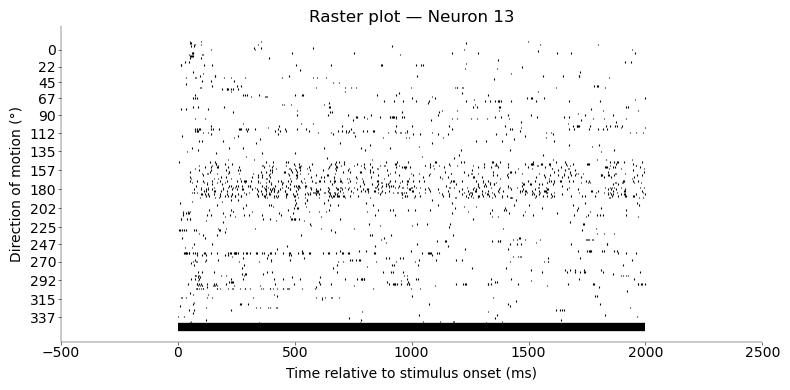

C:\Users\andre\AppData\Local\Temp\ipykernel_16000\224280136.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


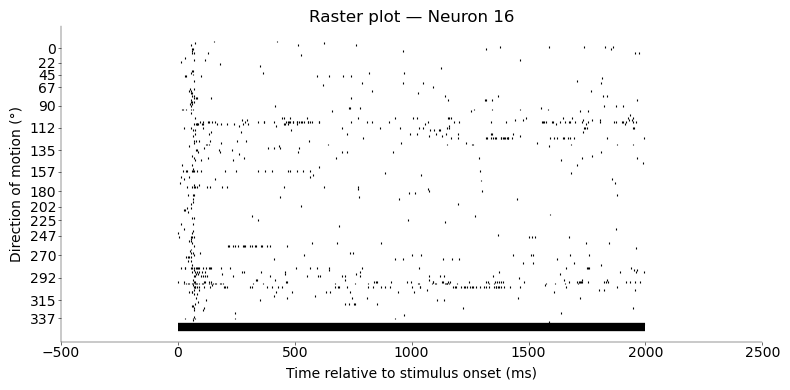

C:\Users\andre\AppData\Local\Temp\ipykernel_16000\224280136.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


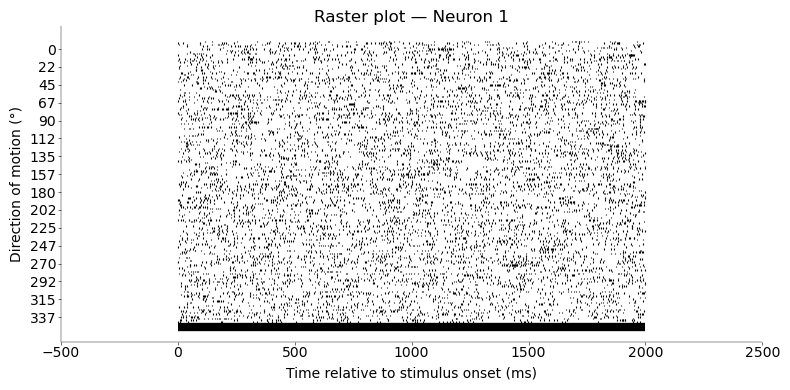

In [157]:
# ---------------------------------
# Find and explain examples? (1 pt)
# ---------------------------------
# average over the full 0–stimDur window, per trial
rates = (
    spikes.query("stimPeriod")
    .groupby(["Neuron", "Dir", "Trial"])
    .size()  # spike count
    .reset_index(name="count")
    .assign(rate=lambda df: df["count"] / (stimDur / 1000))
    .groupby(["Neuron", "Dir"])["rate"]
    .mean()  # mean across trials
    .unstack()  # rows=Neuron, cols=Dir
)
dsis = {}
osis = {}
for nm, row in rates.iterrows():
    pref = row.max()
    pref_dir = row.idxmax()
    null_dir = (pref_dir + 180) % 360
    perp_dirs = [(pref_dir + 90) % 360, (pref_dir - 90) % 360]

    R_null = row[null_dir]
    R_perp = row[perp_dirs].mean()

    dsis[nm] = (pref - R_null) / (pref + R_null + 1e-6)
    osis[nm] = (pref - R_perp) / (pref + R_perp + 1e-6)

# then:
dir_sel = [n for n in dsis if dsis[n] > 0.5]
ori_sel = [n for n in osis if osis[n] > 0.5 and dsis[n] < 0.2]
non_sel = [n for n in dsis if abs(dsis[n]) < 0.1 and abs(osis[n]) < 0.1]

print("Direction‐selective examples:", dir_sel[:3])
print("Orientation‐selective examples:", ori_sel[:3])
print("Non‐selective examples:", non_sel[:3])

for neuron in [dir_sel[1], ori_sel[3], non_sel[0]]:
    plotRaster(spikes, neuron)

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

For full points, the optimal kernel- or bin-width needs to be computed.

Implement one of them in the function `plotPSTH()`. If you dont use a dataframe you may need to change the interface of the function.


*Grading: 4 pts*


In [158]:
from scipy.stats import norm

nTrials = 11  # number of trials per direction


def select_optimal_binwidth(
    rel_times, T, n_trials, delta_min=1.0, delta_max=None, n_deltas=200
):
    """
    Shimazaki & Shinomoto (2007) algorithm to pick histogram bin width Δ,
    with log‐spaced search capped at T/10 and a Freedman–Diaconis fallback.

    Parameters
    ----------
    rel_times : array-like (ms)
        all spike times within [0, T]
    T : float (ms)
        total observation window
    n_trials : int
        number of repeated trials
    delta_min : float (ms)
        smallest bin width to try
    delta_max : float (ms), optional
        largest bin width to try; defaults to T/10
    n_deltas : int
        number of candidate widths in the log‐spaced grid

    Returns
    -------
    Δ_opt_ms : float
        optimal bin width (ms)
    """
    # convert to seconds
    rel_s = np.asarray(rel_times) / 1000.0
    T_s = T / 1000.0

    # cap delta_max at T/10 if not provided
    if delta_max is None:
        delta_max = T / 20.0
    else:
        delta_max = min(delta_max, T / 20.0)

    # endpoints in seconds
    del_min_s = delta_min / 1000.0
    del_max_s = delta_max / 1000.0

    # log‐spaced candidate Δ_s
    deltas_s = np.logspace(np.log10(del_min_s), np.log10(del_max_s), n_deltas)

    # compute Shimazaki–Shinomoto cost for each Δ_s
    costs = np.zeros_like(deltas_s)
    for i, Δ_s in enumerate(deltas_s):
        edges = np.arange(0, T_s + Δ_s, Δ_s)
        kis, _ = np.histogram(rel_s, bins=edges)
        kis = kis.astype(float) / n_trials
        k_bar = kis.mean()
        v = ((kis - k_bar) ** 2).mean()
        costs[i] = (2 * k_bar - v) / (Δ_s**2)

    # pick the Δ_s that minimizes the cost
    idx = np.argmin(costs)
    Δ_opt_ms = deltas_s[idx] * 1000.0

    # if the minimum is at the boundary, fallback to Freedman–Diaconis
    if idx == 0 or idx == len(deltas_s) - 1:
        x = np.asarray(rel_times)
        iqr = np.subtract(*np.percentile(x, [75, 25]))
        Δ_fd = 2 * iqr * (x.size ** (-1 / 3))
        Δ_opt_ms = np.clip(Δ_fd, delta_min, delta_max)

    return Δ_opt_ms


def plotPSTH(spikes: pd.DataFrame, neuron: int, stimDur=2000.0, n_trials=11):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Implement one of the spike rate estimates (3 pts)
    # -------------------------------------------------
    # filter data
    df = spikes[(spikes.Neuron == neuron) & spikes.stimPeriod]
    dirs = np.sort(df.Dir.unique())
    n_trials = df.groupby("Dir").Trial.nunique().iloc[0]

    # compute optimal PSTH bin width Δ*
    Δ = select_optimal_binwidth(df.relTime.values, stimDur, n_trials)

    # PSTH edges & centers
    psth_edges = np.arange(0, stimDur + Δ, Δ)
    psth_centers = psth_edges[:-1] + Δ / 2

    # time vector for SDF (±500 ms)
    bg, ag = 500, 500
    tvec = np.arange(-bg, stimDur + ag + 1)

    # Gaussian kernel σ=20 ms
    sigma = 20.0
    kt = np.arange(-3 * sigma, 3 * sigma + 1)
    gauss = norm.pdf(kt, 0, sigma)
    gauss /= gauss.sum()

    # 3) set up 4×4 grid
    ncols = 4
    nrows = int(np.ceil(len(dirs) / ncols))
    fig, axes = plt.subplots(nrows, ncols, sharex=True, figsize=(14, 3 * nrows))
    axes = axes.flatten()

    for ax, d in zip(axes, dirs):
        sub = df[df.Dir == d]

        # PSTH → spikes/sec
        trial_counts = []
        for t in range(1, n_trials + 1):
            st = sub[sub.Trial == t].relTime.values
            cnts, _ = np.histogram(st, bins=psth_edges)
            trial_counts.append(cnts)
        rate_hist = np.mean(trial_counts, axis=0) / (Δ / 1000.0)

        # SDF → all-trial hist → sp/s → smooth
        hist1, _ = np.histogram(sub.relTime.values, bins=np.append(tvec, tvec[-1] + 1))
        rate1 = hist1 / n_trials * 1000.0
        sdf = np.convolve(rate1, gauss, mode="same")

        # plot
        ax.axvspan(0, stimDur, color="0.9", zorder=-1)
        ax.bar(
            psth_centers, rate_hist, width=Δ, color="0.7", edgecolor="none", alpha=0.7
        )
        ax.plot(tvec, sdf, color="C0", lw=1.5)

        # format
        ax.set_xlim(-bg, stimDur + ag)
        ax.set_ylim(0, max(rate_hist.max(), sdf.max()) * 1.1)
        ax.set_title(f"{int(d)}°")
        ax.set_ylabel("sp/s")

    # turn off any unused axes
    for ax in axes[len(dirs) :]:
        ax.axis("off")

    # shared legend & scale bar
    axes[0].bar([], [], color="0.7", alpha=0.7, label=f"PSTH Δ*={Δ:.1f} ms")
    axes[0].plot([], [], color="C0", lw=1.5, label="SDF σ=20 ms")
    axes[0].legend(loc="upper left")
    axes[0].plot([-400, -400], [0, 50], "k", lw=2)
    axes[0].text(-390, 25, "50 sp/s", va="center")

    # global labels & title
    fig.text(0.5, 0.04, "Time rel. to stimulus onset (ms)", ha="center")
    fig.suptitle(f"Neuron {neuron} — Δ*={Δ:.1f} ms, σ={sigma:.1f} ms", y=0.98)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Plot the same 3 examples you selected in Task 1

C:\Users\andre\AppData\Local\Temp\ipykernel_16000\24118823.py:169: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


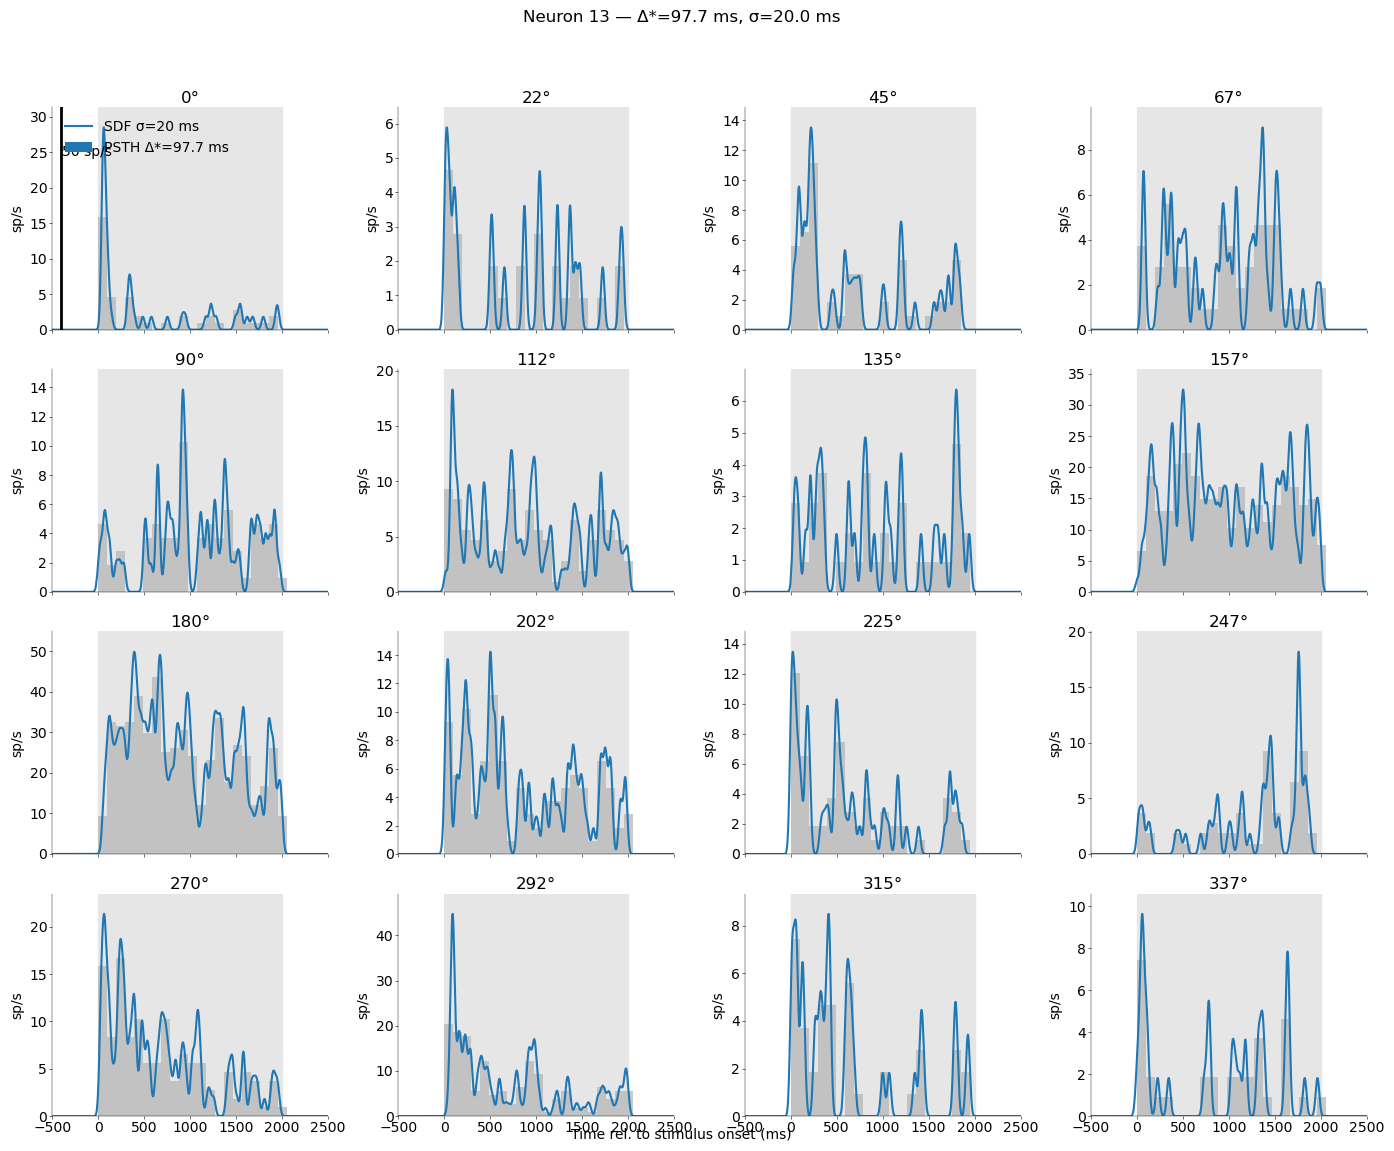

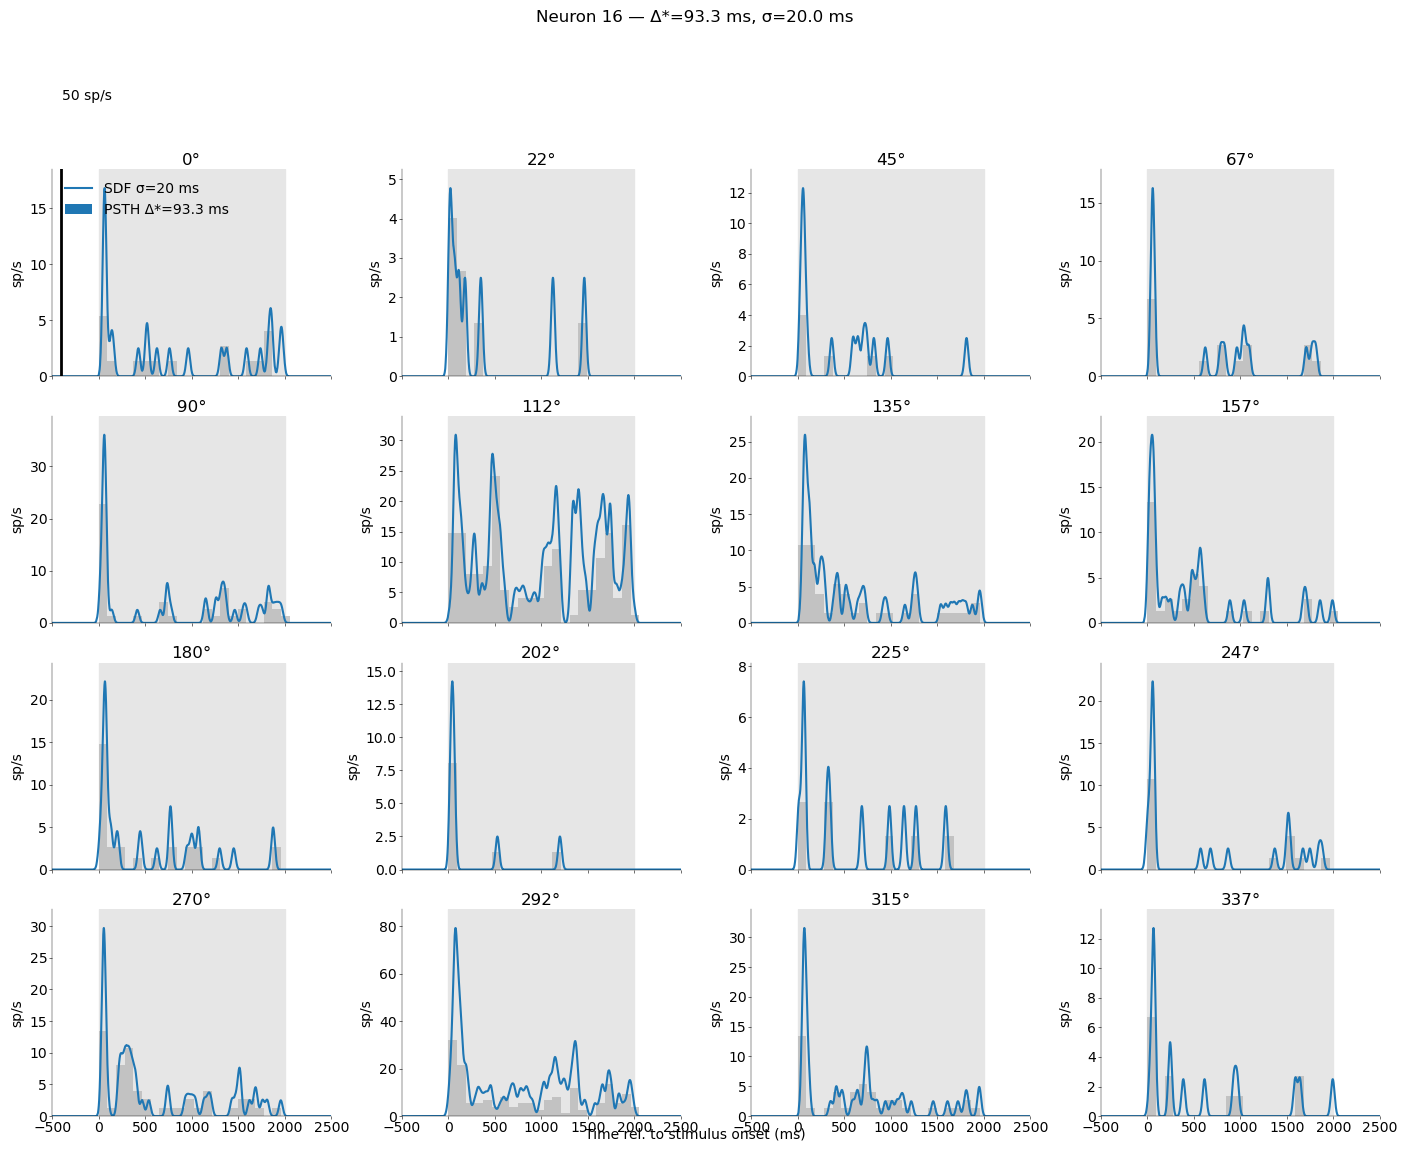

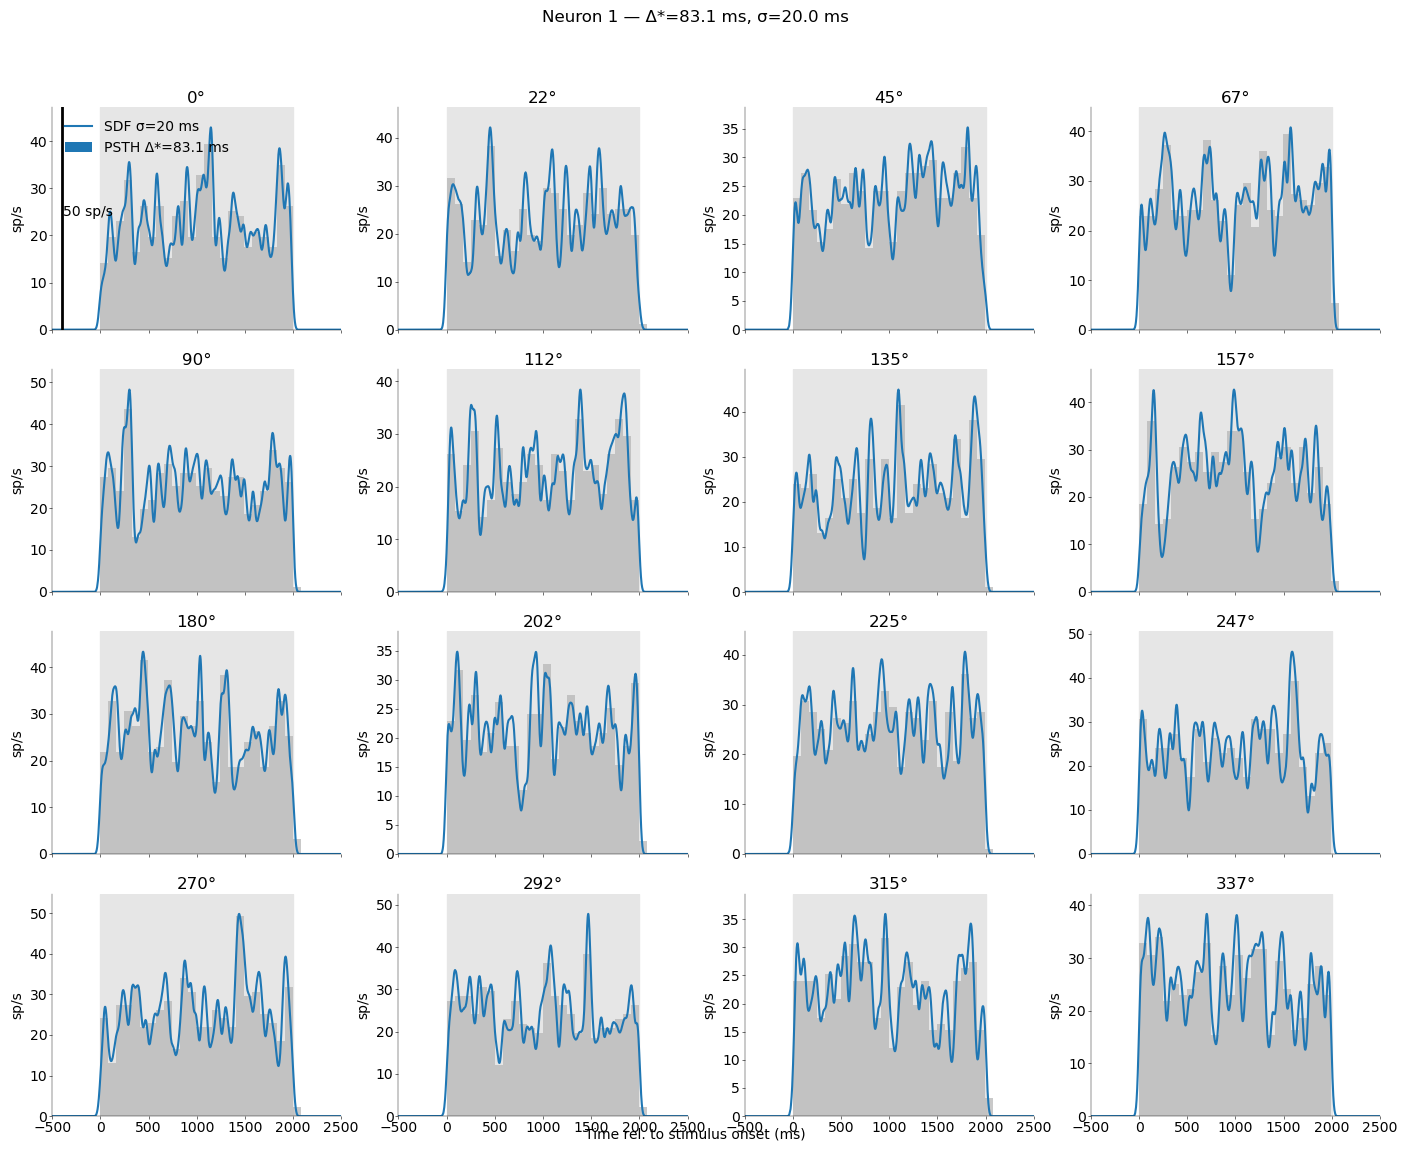

In [159]:
for neuron in [dir_sel[1], ori_sel[3], non_sel[0]]:
    plotPSTH(spikes, neuron)

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactly. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test your code.

*Grading: 5 pts*

In [160]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve
        with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------
    return np.exp(α + κ * (np.cos(2 * (θ - ϕ)) - 1) + ν * (np.cos(θ - ϕ) - 1))

Plot the von Mises function while varying the parameters systematically.

C:\Users\andre\AppData\Local\Temp\ipykernel_16000\2235227151.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


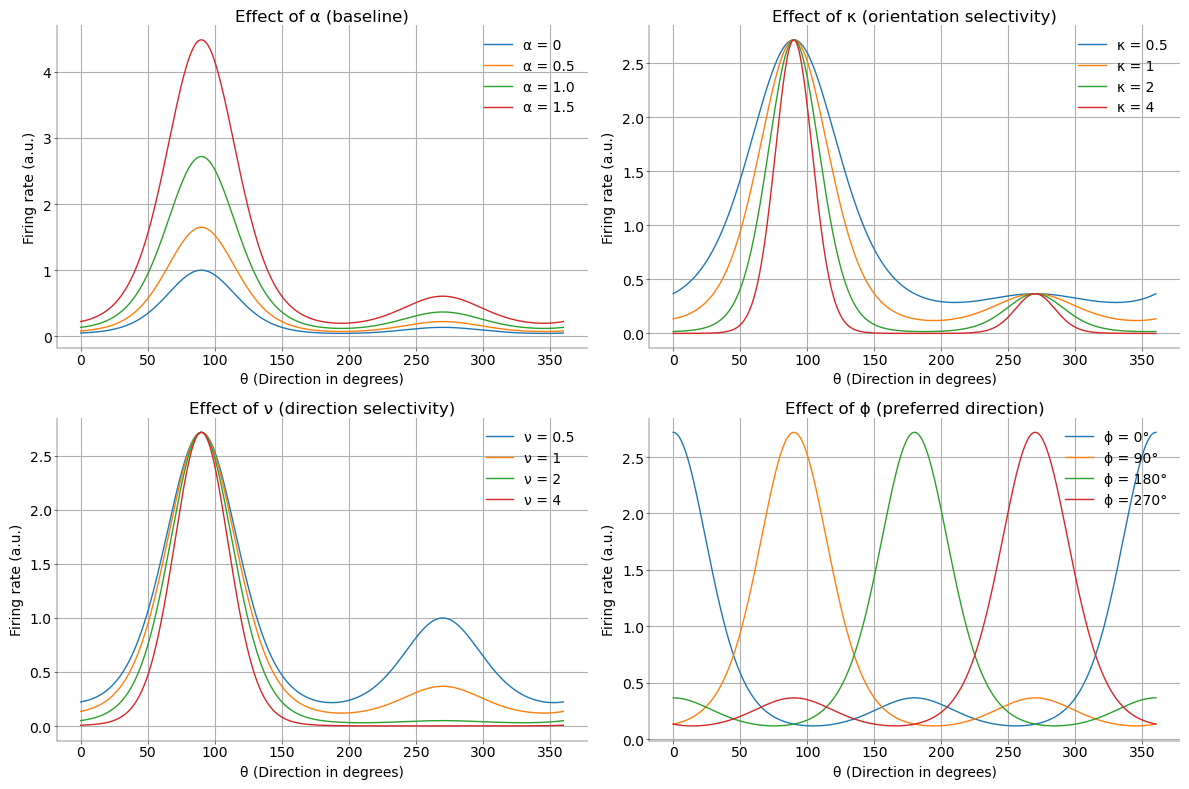

In [161]:
# ------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (2 pts)
# ------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt


def plot_vonMises_param_effects():
    θ = np.linspace(0, 360, 500)

    # Baseline parameters
    α = 1.0
    κ = 1.0
    ν = 1.0
    ϕ = 90.0

    theta_rad = np.deg2rad(θ)  # convert degrees to radians
    phi_rad = np.deg2rad(ϕ)  # convert degrees to radians

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    # Vary α (baseline)
    for a in [0, 0.5, 1.0, 1.5]:
        f = vonMises(theta_rad, α=a, κ=κ, ν=ν, ϕ=phi_rad)
        axs[0].plot(θ, f, label=f"α = {a}")
    axs[0].set_title("Effect of α (baseline)")
    axs[0].legend()

    # Vary κ (orientation tuning sharpness)
    for k in [0.5, 1, 2, 4]:
        f = vonMises(theta_rad, α=α, κ=k, ν=ν, ϕ=phi_rad)
        axs[1].plot(θ, f, label=f"κ = {k}")
    axs[1].set_title("Effect of κ (orientation selectivity)")
    axs[1].legend()

    # Vary ν (direction tuning sharpness)
    for n in [0.5, 1, 2, 4]:
        f = vonMises(theta_rad, α=α, κ=κ, ν=n, ϕ=phi_rad)
        axs[2].plot(θ, f, label=f"ν = {n}")
    axs[2].set_title("Effect of ν (direction selectivity)")
    axs[2].legend()

    # Vary ϕ (preferred direction)
    for phi in [0, 90, 180, 270]:
        ϕ_rad = np.deg2rad(phi)
        f = vonMises(theta_rad, α=α, κ=κ, ν=ν, ϕ=ϕ_rad)
        axs[3].plot(θ, f, label=f"ϕ = {phi}°")
    axs[3].set_title("Effect of ϕ (preferred direction)")
    axs[3].legend()

    for ax in axs:
        ax.set_xlabel("θ (Direction in degrees)")
        ax.set_ylabel("Firing rate (a.u.)")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


plot_vonMises_param_effects()

#### Plot the von Mises function while varying the parameters systematically and explain what they do.

The von Mises function used for fitting tuning curves is:
$$ f(\theta) = \exp(\alpha + \kappa (\cos (2(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

The parameters each distinctly describe the shape of the distribution: 
* $\alpha$ - Baseline/Amplitude - is related to the neuron's baseline firing rate or the overall responsiveness. A larger
alpha generally means the neuron fires more across all tested directions, or has a higher peak response. We see in the plot that going from a range of $\alpha=0$ to $\alpha=1.5$ all peaks show respective increase.
* $\kappa$ -  Orientation Selectivity / Bimodal Component Strength - this term creates a response pattern that is $180^\circ$ periodic (i.e., it has two peaks in a $360^\circ$ range). kappa controls the strength and sharpness of this bimodal component.
* $\nu$ - Direction Selectivity - Controls the strength and sharpness of this unimodal component. We see that $\nu=4$ has a flat bimodal peak.
* $\phi$ - Preferred Direction/Orientation - $\phi$ is the neuron's preferred direction (if
$\nu$ is dominant) or preferred orientation axis (if $\kappa$ is dominant). It shifts the entire tuning curve horizontally along the direction axis. We note the shift in peak as we vary the $\phi$ above.

In [162]:
def compute_spike_count_matrix(counts: np.ndarray, dirs: np.ndarray) -> np.ndarray:
    """Compute the spike count matrix from the counts and dirs.

    Parameters
    ----------
    counts: np.ndarray
        The spike counts for each trial.

    dirs: np.ndarray
        The stimulus directions for each trial.

    Returns
    -------
    spike_count_matrix: np.ndarray
        The computed spike count matrix.
    """
    unique_stim_directions_deg = np.unique(dirs)  # Shape: (nDirs,)
    num_unique_directions = len(unique_stim_directions_deg)
    logger.debug(f"Unique stimulus directions: {unique_stim_directions_deg}")
    logger.debug(f"Number of unique stimulus directions: {num_unique_directions}")

    # Get the unique stimulus directions, sorted. These will be the columns of our matrix.
    unique_stim_directions_deg = np.unique(dirs)  # Shape: (nDirs,)
    num_unique_directions = len(unique_stim_directions_deg)
    # Initialize the spike count matrix `x` with shape (nTrials, nDirs)
    # x_jk: j-th trial (row), k-th direction (column)
    spike_count_matrix_x = np.zeros((nTrials, num_unique_directions))
    # Populate the matrix
    for k_idx, direction_value in enumerate(unique_stim_directions_deg):
        # Extract all spike counts from the 1D 'counts' array that correspond to the current 'direction_value'
        counts_for_this_direction = counts[dirs == direction_value]
        # The get_data function should ensure that 'counts_for_this_direction'
        # has exactly 'nTrials' elements.
        if len(counts_for_this_direction) == nTrials:
            spike_count_matrix_x[:, k_idx] = counts_for_this_direction
        else:
            # This part handles unexpected lengths, though get_data should prevent this.
            # If fewer than nTrials, pad with zeros (already done by get_data, but good for robustness).
            # If more than nTrials (unlikely), take the first nTrials.
            actual_trials_found = len(counts_for_this_direction)
            if actual_trials_found >= nTrials:
                spike_count_matrix_x[:, k_idx] = counts_for_this_direction[:nTrials]
            else:  # actual_trials_found < nTrials
                spike_count_matrix_x[:actual_trials_found, k_idx] = (
                    counts_for_this_direction
                )
                # The remaining (nTrials - actual_trials_found) elements will stay zero
                # due to initialization with np.zeros.
    return spike_count_matrix_x

In [163]:
def inital_von_mises_params(
    mean_counts_to_fit: np.ndarray, unique_dirs_rad: np.ndarray
) -> tuple:
    """Initial guess for the von Mises parameters based on mean counts.
    Parameters
    ----------
    mean_counts_to_fit: np.ndarray
        The mean counts for each direction.
    unique_dirs_rad: np.ndarray
        The unique directions in radians.
    Returns
    -------
    tuple: (alpha_guess, kappa_guess, nu_guess, phi_guess_rad)
        Initial guesses for the parameters of the von Mises function.
    """
    # Robust initial guesses:
    if not np.any(
        mean_counts_to_fit > 1e-9
    ):  # Handle cases where all mean counts are zero or tiny
        alpha_guess = np.log(1e-6)  # A small baseline
        phi_guess_rad = 0.0  # Default preferred direction
    else:
        # For alpha, use log of mean of positive counts, or log of max if all else fails
        positive_mean_counts = mean_counts_to_fit[mean_counts_to_fit > 1e-9]
        if len(positive_mean_counts) > 0:
            alpha_guess = np.log(np.maximum(1e-6, np.mean(positive_mean_counts)))
        else:  # Should be caught by the outer if, but as a fallback
            alpha_guess = np.log(np.maximum(1e-6, np.max(mean_counts_to_fit)))

        phi_guess_rad = unique_dirs_rad[np.argmax(mean_counts_to_fit)]

    kappa_guess = 1.0  # Initial guess for bimodal strength
    nu_guess = 1.0  # Initial guess for unimodal strength
    return alpha_guess, kappa_guess, nu_guess, phi_guess_rad

In [164]:
def plot_tuning_curve_fit(
    neuron_id: int,
    counts: np.ndarray,
    dirs: np.ndarray,
    mean_counts_to_fit: np.ndarray,
    p_opt: np.ndarray,
    r_squared: float = None,
) -> None:
    """Plot the tuning curve fit for a single neuron.
    Parameters
    ----------
    neuron_id: int
        The ID of the neuron being plotted.
    counts: np.ndarray
        The spike counts for each trial.
    dirs: np.ndarray
        The stimulus directions for each trial.
    mean_counts_to_fit: np.ndarray
        The mean counts for each direction.
    p_opt: np.ndarray
        The optimized parameters from the von Mises fit.
    r_squared: float, optional
        The R-squared value of the fit, if available.
    """
    plt.figure(figsize=(10, 7))  # Adjusted figure size for better layout
    # 1. Plot individual trial spike counts (scatter plot)
    # Add some jitter to x-values for better visibility if many trials per direction
    unique_stim_directions_deg = np.unique(dirs)
    unique_dir_vals_plot = np.unique(dirs)
    dir_spacing = (
        np.min(np.diff(unique_dir_vals_plot)) if len(unique_dir_vals_plot) > 1 else 22.5
    )  # Default spacing
    jitter_strength = dir_spacing * 0.05  # Small jitter

    # Create a mapping from original direction to jittered direction for consistency
    # Only apply jitter if there are multiple trials for a direction, otherwise center it.
    jittered_dirs = np.copy(dirs).astype(float)
    for ud in unique_dir_vals_plot:
        trials_for_dir_mask = dirs == ud
        num_trials_this_dir = np.sum(trials_for_dir_mask)
        if num_trials_this_dir > 1:
            jittered_dirs[trials_for_dir_mask] += np.random.uniform(
                -jitter_strength, jitter_strength, num_trials_this_dir
            )

    plt.scatter(
        jittered_dirs,
        counts,
        alpha=0.3,
        s=25,
        color="darkgray",
        label="Individual Trial Counts",
        zorder=1,
    )

    # 2. Plot average spike counts per direction
    # Calculate standard error of the mean (SEM) for error bars if desired
    # sem_counts = np.std(spike_count_matrix_x, axis=0) / np.sqrt(spike_count_matrix_x.shape[0])
    # plt.errorbar(unique_stim_directions_deg, mean_counts_to_fit, yerr=sem_counts,
    #              fmt='o', color='dodgerblue', markersize=8, capsize=5,
    #              label='Mean Counts (±SEM)', zorder=2)
    # Or simpler, just plot mean points:
    plt.plot(
        unique_stim_directions_deg,
        mean_counts_to_fit,
        "o",
        color="dodgerblue",
        markersize=8,
        label="Mean Spike Count",
        zorder=2,
    )

    # 3. Plot the fitted von Mises curve (if fit was successful)
    if p_opt is not None:
        theta_plot_deg = np.linspace(0, 360, 361)  # Smooth range of angles in degrees
        theta_plot_rad = np.deg2rad(
            theta_plot_deg
        )  # Convert to radians for vonMises function

        fitted_values = vonMises(theta_plot_rad, *p_opt)

        plt.plot(
            theta_plot_deg,
            fitted_values,
            "-",
            color="red",
            linewidth=2.5,
            label=(
                f"Von Mises Fit (R²={r_squared:.2f})"
                if r_squared is not None
                else "Von Mises Fit"
            ),
            zorder=3,
        )
    else:
        logger.info(f"Neuron {neuron_id if neuron_id else 'Unknown'}: No fit to plot.")

    plt.xlabel("Direction of motion (degrees)")
    plt.ylabel("Spike count")
    title_parts = ["Tuning Curve"]
    if neuron_id is not None:
        title_parts.append(f"Neuron {neuron_id}")
    if p_opt is None:
        title_parts.append("(Fit Failed)")

    plt.title(" - ".join(title_parts))
    plt.xticks(np.arange(0, 361, 45))
    plt.xlim(-10, 370)  # Give a bit of space around 0 and 360

    # Adjust y-limits dynamically
    min_y_val = 0
    if len(counts) > 0:
        min_y_val = min(0, np.min(counts) - 1)
        max_y_val = np.max(counts) + max(
            1, np.std(counts) * 0.5
        )  # Ensure some space above max count
        if p_opt is not None:  # Also consider fitted curve for ymax
            max_y_val = max(max_y_val, np.max(fitted_values) * 1.1)
        plt.ylim(bottom=min_y_val, top=max_y_val)
    else:
        plt.ylim(bottom=0, top=1)  # Default if no counts

    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [165]:
def tuningCurve(
    counts: np.ndarray, dirs: np.ndarray, show: bool = True, neuron_id=None
) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with
    direction dir using a **least-squares fit**.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.
    neuron_id: int, optional
        The ID of the neuron being fitted. Used for logging and plotting.
        If None, will be set to 'Unknown' in logs and plots.

    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------
    logger.info("Fitting tuning curve...")
    logger.info(f"Counts: {counts.shape}")
    logger.info(f"Dirs: {dirs.shape}")

    spike_count_matrix_x = compute_spike_count_matrix(counts, dirs)

    logger.info(f"Spike count matrix shape: {spike_count_matrix_x.shape}")
    logger.info(f"Spike count matrix: {spike_count_matrix_x}")

    # ------------------------------------------------------------
    # fit the von Mises tuning curve to the spike counts (0.5 pts)
    # ------------------------------------------------------------

    # 1. Calculate mean spike counts per direction
    mean_counts_to_fit = np.mean(spike_count_matrix_x, axis=0)
    logger.info(f"Mean counts to fit: {mean_counts_to_fit}")

    # 2. Get unique directions (degrees) and convert to radians
    # 'dirs' is the original 1D array of directions for all trials passed to tuningCurve
    unique_stim_directions_deg = np.unique(dirs)
    unique_dirs_rad = np.deg2rad(unique_stim_directions_deg)
    logger.info(f"Unique directions (radians) for fitting: {unique_dirs_rad}")

    # Check if there's enough data to fit (at least as many points as parameters)
    if len(unique_dirs_rad) < 4:  # vonMises has 4 parameters
        logger.warning(
            f"Not enough unique directions ({len(unique_dirs_rad)}) to fit the von Mises model. Need at least 4. Skipping fit."
        )
        p_opt = None  # Indicate fit failed
    else:
        alpha_guess, kappa_guess, nu_guess, phi_guess_rad = inital_von_mises_params(
            mean_counts_to_fit, unique_dirs_rad
        )
        p0 = [alpha_guess, kappa_guess, nu_guess, phi_guess_rad]
        logger.info(f"Initial parameter guesses (p0): {p0}")
        # Bounds: alpha, kappa>=0, nu>=0, phi in [0, 2*pi]
        bounds = ([-np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, 2 * np.pi])
        # Fit the von Mises function to the mean counts
        # 4. Perform the non-linear least squares fit
        r_squared = None
        try:
            p_opt, p_cov = opt.curve_fit(
                f=vonMises,  # Your vonMises function (make sure it's defined and accessible)
                xdata=unique_dirs_rad,
                ydata=mean_counts_to_fit,
                p0=p0,
                bounds=bounds,
                maxfev=5000,  # Maximum number of function evaluations
            )
            residuals = mean_counts_to_fit - vonMises(unique_dirs_rad, *p_opt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((mean_counts_to_fit - np.mean(mean_counts_to_fit)) ** 2)
            if ss_tot == 0:  # Avoid division by zero if all mean_counts are the same
                r_squared = 1.0 if ss_res < 1e-9 else 0.0
            else:
                r_squared = 1 - (ss_res / ss_tot)
            logger.info(
                f"Neuron {neuron_id if neuron_id else 'Unknown'}: R-squared = {r_squared:.3f}"
            )
            logger.info(f"Optimized parameters (p_opt): {p_opt}")
        except RuntimeError:
            logger.warning(
                "RuntimeError: Optimal parameters not found during curve_fit. Fit failed."
            )
            p_opt = (
                None  # Or assign np.full(4, np.nan) if you prefer NaNs for failed fits
            )
        except ValueError as e:
            logger.warning(f"ValueError during curve_fit: {e}. Fit failed.")
            p_opt = None

        if show:
            # --------------------------------------------
            # plot the data and fitted tuning curve (1 pt)
            # --------------------------------------------
            plot_tuning_curve_fit(
                neuron_id=neuron_id,
                counts=counts,  # spike_count_matrix_x.flatten(),
                dirs=dirs,
                mean_counts_to_fit=mean_counts_to_fit,
                p_opt=p_opt,
                r_squared=r_squared,  # Replace with actual R-squared value if available
                # r_squared=1 - (np.sum((mean_counts_to_fit - vonMises(unique_dirs_rad, *p_opt))**2) / np.sum((mean_counts_to_fit - np.mean(mean_counts_to_fit))**2))
            )
        return p_opt

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [166]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:
            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

INFO:__main__:Fitting tuning curve...
INFO:__main__:Counts: (176,)
INFO:__main__:Dirs: (176,)
INFO:__main__:Spike count matrix shape: (11, 16)
INFO:__main__:Spike count matrix: [[ 0. 16. 13.  0.  0.  0.  0.  0.  0. 48. 26.  3.  0.  0.  1.  0.]
 [ 0.  9. 29.  0.  1.  0.  0.  0.  0. 44. 41.  1.  0.  0.  0.  0.]
 [ 0. 25. 17.  0.  0.  0.  0.  0.  0. 45. 30.  2.  0.  0.  0.  0.]
 [ 0. 15.  3.  0.  0.  0.  0.  0.  0. 44. 40.  2.  0.  0.  0.  0.]
 [ 0. 19. 24.  0.  0.  0.  0.  0.  3. 43. 55.  1.  0.  0.  0.  0.]
 [ 0. 10. 15.  0.  0.  0.  0.  0.  1. 52. 32.  0.  0.  0.  0.  0.]
 [ 0. 11. 14.  0.  0.  0.  0.  0.  0. 37. 42.  0.  0.  0.  0.  0.]
 [ 0. 14. 16.  0.  0.  0.  0.  0.  0. 48. 19.  0.  0.  0.  0.  0.]
 [ 0. 20. 16.  0.  0.  0.  0.  0.  0. 32. 39.  0.  0.  0.  0.  0.]
 [ 0. 10. 13.  0.  0.  0.  0.  0.  0. 54. 47.  0.  0.  0.  0.  0.]
 [ 0. 24. 14.  0.  0.  0.  0.  0.  0. 41. 31.  0.  0.  0.  0.  0.]]
INFO:__main__:Mean counts to fit: [ 0.         15.72727273 15.81818182  0.          0

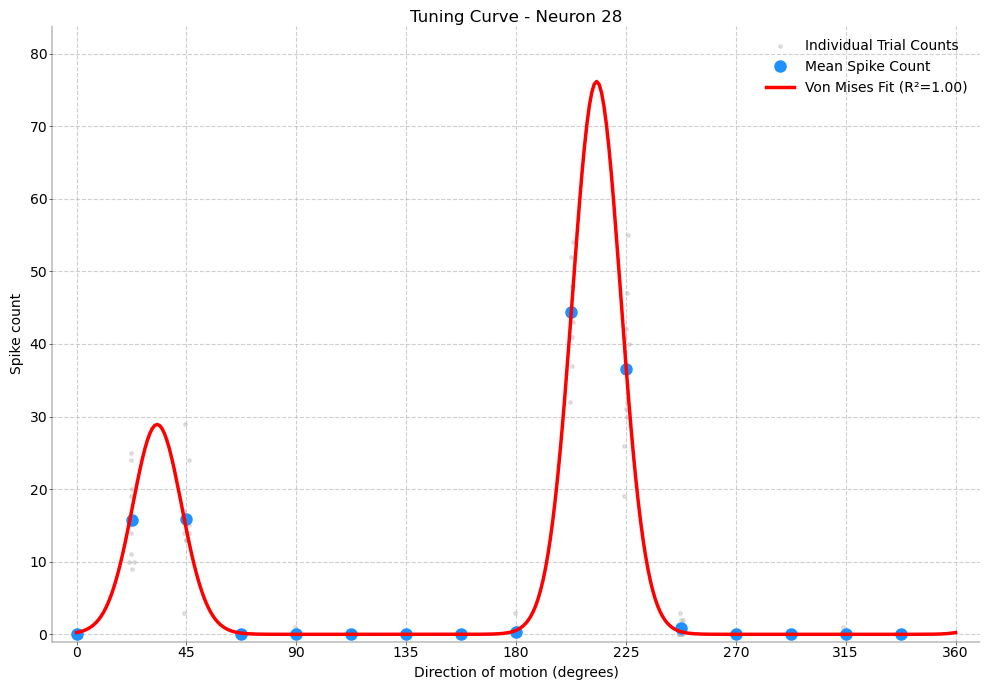

INFO:__main__:Fitting tuning curve...
INFO:__main__:Counts: (176,)
INFO:__main__:Dirs: (176,)
INFO:__main__:Spike count matrix shape: (11, 16)
INFO:__main__:Spike count matrix: [[ 5.  1. 15. 19.  9.  2.  4.  4.  3.  3.  5.  4.  3.  1.  1.  6.]
 [ 6.  4. 14. 13.  3.  2.  3.  9.  0.  1.  6. 11.  6.  0.  0.  2.]
 [ 3.  1. 14. 20.  3.  2.  0.  3.  0.  0.  1.  7. 20.  0.  0.  1.]
 [ 2.  2. 26. 19. 13.  4.  0.  1.  2.  1.  7.  8.  5.  0.  0.  4.]
 [ 1.  2.  1. 23.  8.  1.  5.  2.  3.  8. 16.  6. 15.  0.  0.  6.]
 [ 0.  0. 10. 27.  3.  1.  0.  3.  3.  0.  9.  4.  7.  0.  1.  2.]
 [ 0.  0.  4. 16. 11.  3.  4.  2.  4.  0.  6.  3.  5.  0.  0.  1.]
 [ 0.  0. 28. 25.  5.  2.  1.  5.  4.  0. 11.  7.  4.  0.  0.  0.]
 [ 0.  0. 19. 24.  5.  1. 10.  1.  0.  0.  1.  0.  7.  0.  0.  0.]
 [ 0.  0.  9. 12.  2.  0.  5.  8.  0.  0. 16.  0.  6.  1.  0.  0.]
 [ 0.  0. 19. 12.  7.  2.  1.  3.  0.  0. 24.  1.  2.  1.  0.  0.]]
INFO:__main__:Mean counts to fit: [ 1.54545455  0.90909091 14.45454545 19.09090909  6

Neuron 28: dirs_sorted.shape = (176,), counts_sorted.shape = (176,)


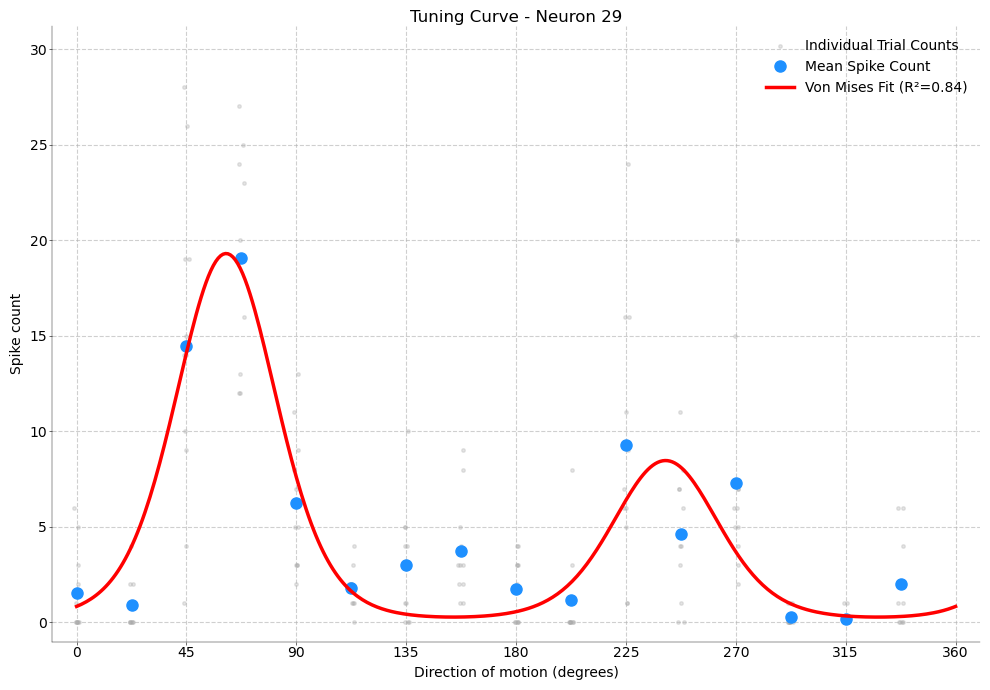

INFO:__main__:Fitting tuning curve...
INFO:__main__:Counts: (176,)


Neuron 29: dirs_sorted.shape = (176,), counts_sorted.shape = (176,)


INFO:__main__:Dirs: (176,)
INFO:__main__:Spike count matrix shape: (11, 16)
INFO:__main__:Spike count matrix: [[ 10.   7.   4.  75.  50.   1.   0.  15.   2.   0.   0.   8.  13.   2.
    2.  10.]
 [ 11.   5.   1.  90.  47.   2.   0.  15.   6.   0.   0.   4.   2.   0.
    1.   9.]
 [  5.   6.   3. 109.  56.   3.   0.   8.  10.   0.   0.   9.   2.   0.
    2.   5.]
 [  8.   4.   2.  57.  46.   1.   0.   5.  14.   4.   0.  10.   1.   0.
    2.  13.]
 [ 10.   3.   1.  94.  43.   0.   0.   7.  12.   3.   0.   2.   4.   0.
    6.  10.]
 [ 11.   7.   5.  67.  52.   0.   0.  12.   6.   1.   0.   6.   4.   0.
    3.   5.]
 [  5.   4.   1.  82.  48.   0.   1.   4.   5.   1.   0.   9.   2.   0.
    3.  11.]
 [  6.   5.   2.  84.  62.   1.   3.   9.   7.   1.   0.  19.   0.   0.
    1.  15.]
 [ 12.   5.   1.  82.  66.   1.   1.   8.   7.   1.   0.   3.   0.   0.
    5.  11.]
 [ 16.   9.   0.  82.  36.   0.   3.  10.   2.   5.   0.  10.   6.   0.
    4.  10.]
 [  8.   4.   0.  93.  47.   0.   2.   8

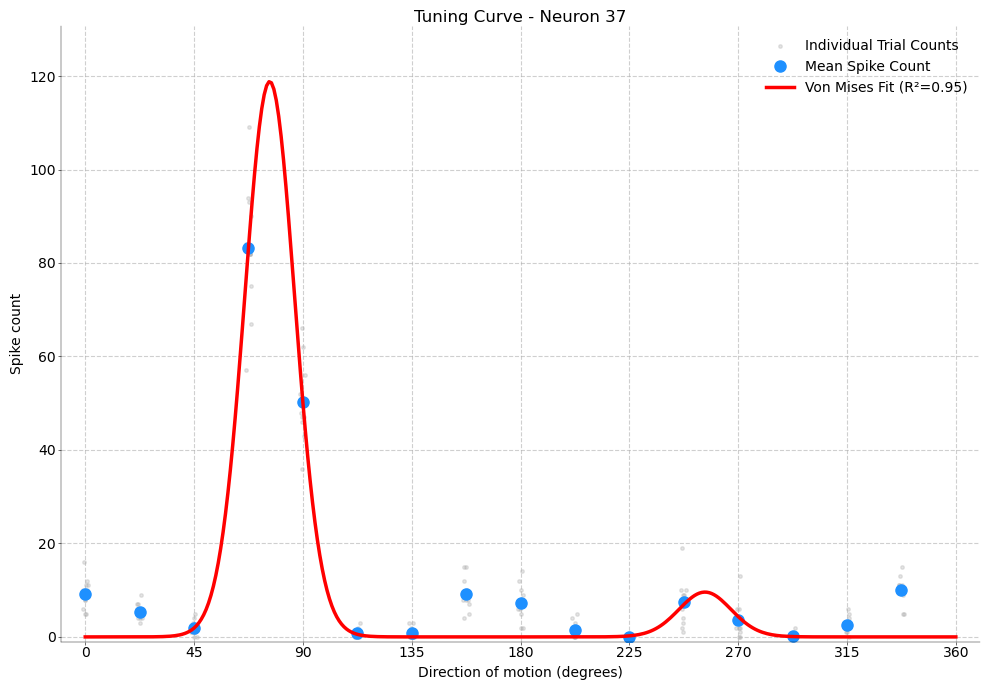

Neuron 37: dirs_sorted.shape = (176,), counts_sorted.shape = (176,)


In [167]:
# ----------------------------------------------------------
# plot the average number of spikes per direction, the spike
# counts from individual trials as well as your optimal fit
# for different neurons (0.5 pts)
# ----------------------------------------------------------
neurons_to_plot = [28, 29, 37]
for neuron in neurons_to_plot:
    dirs_sorted, counts_sorted = get_data(spikes, neuron)
    result = tuningCurve(counts_sorted, dirs_sorted, show=True, neuron_id=neuron)
    if result is not None:
        print(
            f"Neuron {neuron}: dirs_sorted.shape = {dirs_sorted.shape}, counts_sorted.shape = {counts_sorted.shape}"
        )
    else:
        print(f"Neuron {neuron}: No result from tuningCurve()")

### Tuning Curves for neurons visualized

INFO:__main__:Fitting tuning curve...
INFO:__main__:Counts: (176,)
INFO:__main__:Dirs: (176,)
INFO:__main__:Spike count matrix shape: (11, 16)
INFO:__main__:Spike count matrix: [[37. 79. 62. 78. 71. 68. 61. 65. 75. 63. 79. 74. 66. 79. 64. 84.]
 [55. 62. 86. 66. 81. 43. 62. 63. 67. 50. 58. 47. 62. 48. 51. 58.]
 [50. 40. 57. 43. 49. 54. 56. 58. 56. 51. 52. 51. 51. 45. 49. 53.]
 [41. 36. 40. 56. 52. 42. 60. 40. 63. 55. 42. 27. 55. 54. 60. 49.]
 [47. 48. 27. 55. 51. 34. 53. 50. 68. 39. 58. 58. 67. 63. 41. 52.]
 [56. 53. 45. 50. 41. 46. 37. 76. 36. 43. 45. 53. 45. 58. 34. 46.]
 [41. 38. 48. 41. 52. 30. 35. 48. 58. 37. 43. 39. 50. 55. 37. 46.]
 [44. 34. 32. 48. 61. 38. 43. 44. 37. 38. 56. 38. 48. 47. 47. 55.]
 [49. 31. 39. 56. 23. 54. 52. 49. 35. 47. 49. 50. 35. 41. 36. 44.]
 [53. 71. 39. 62. 54. 50. 31. 40. 42. 27. 58. 37. 58. 25. 39. 48.]
 [36. 32. 39. 38. 42. 48. 42. 24. 48. 39. 36. 61. 39. 35. 43. 31.]]
INFO:__main__:Mean counts to fit: [46.27272727 47.63636364 46.72727273 53.90909091 52

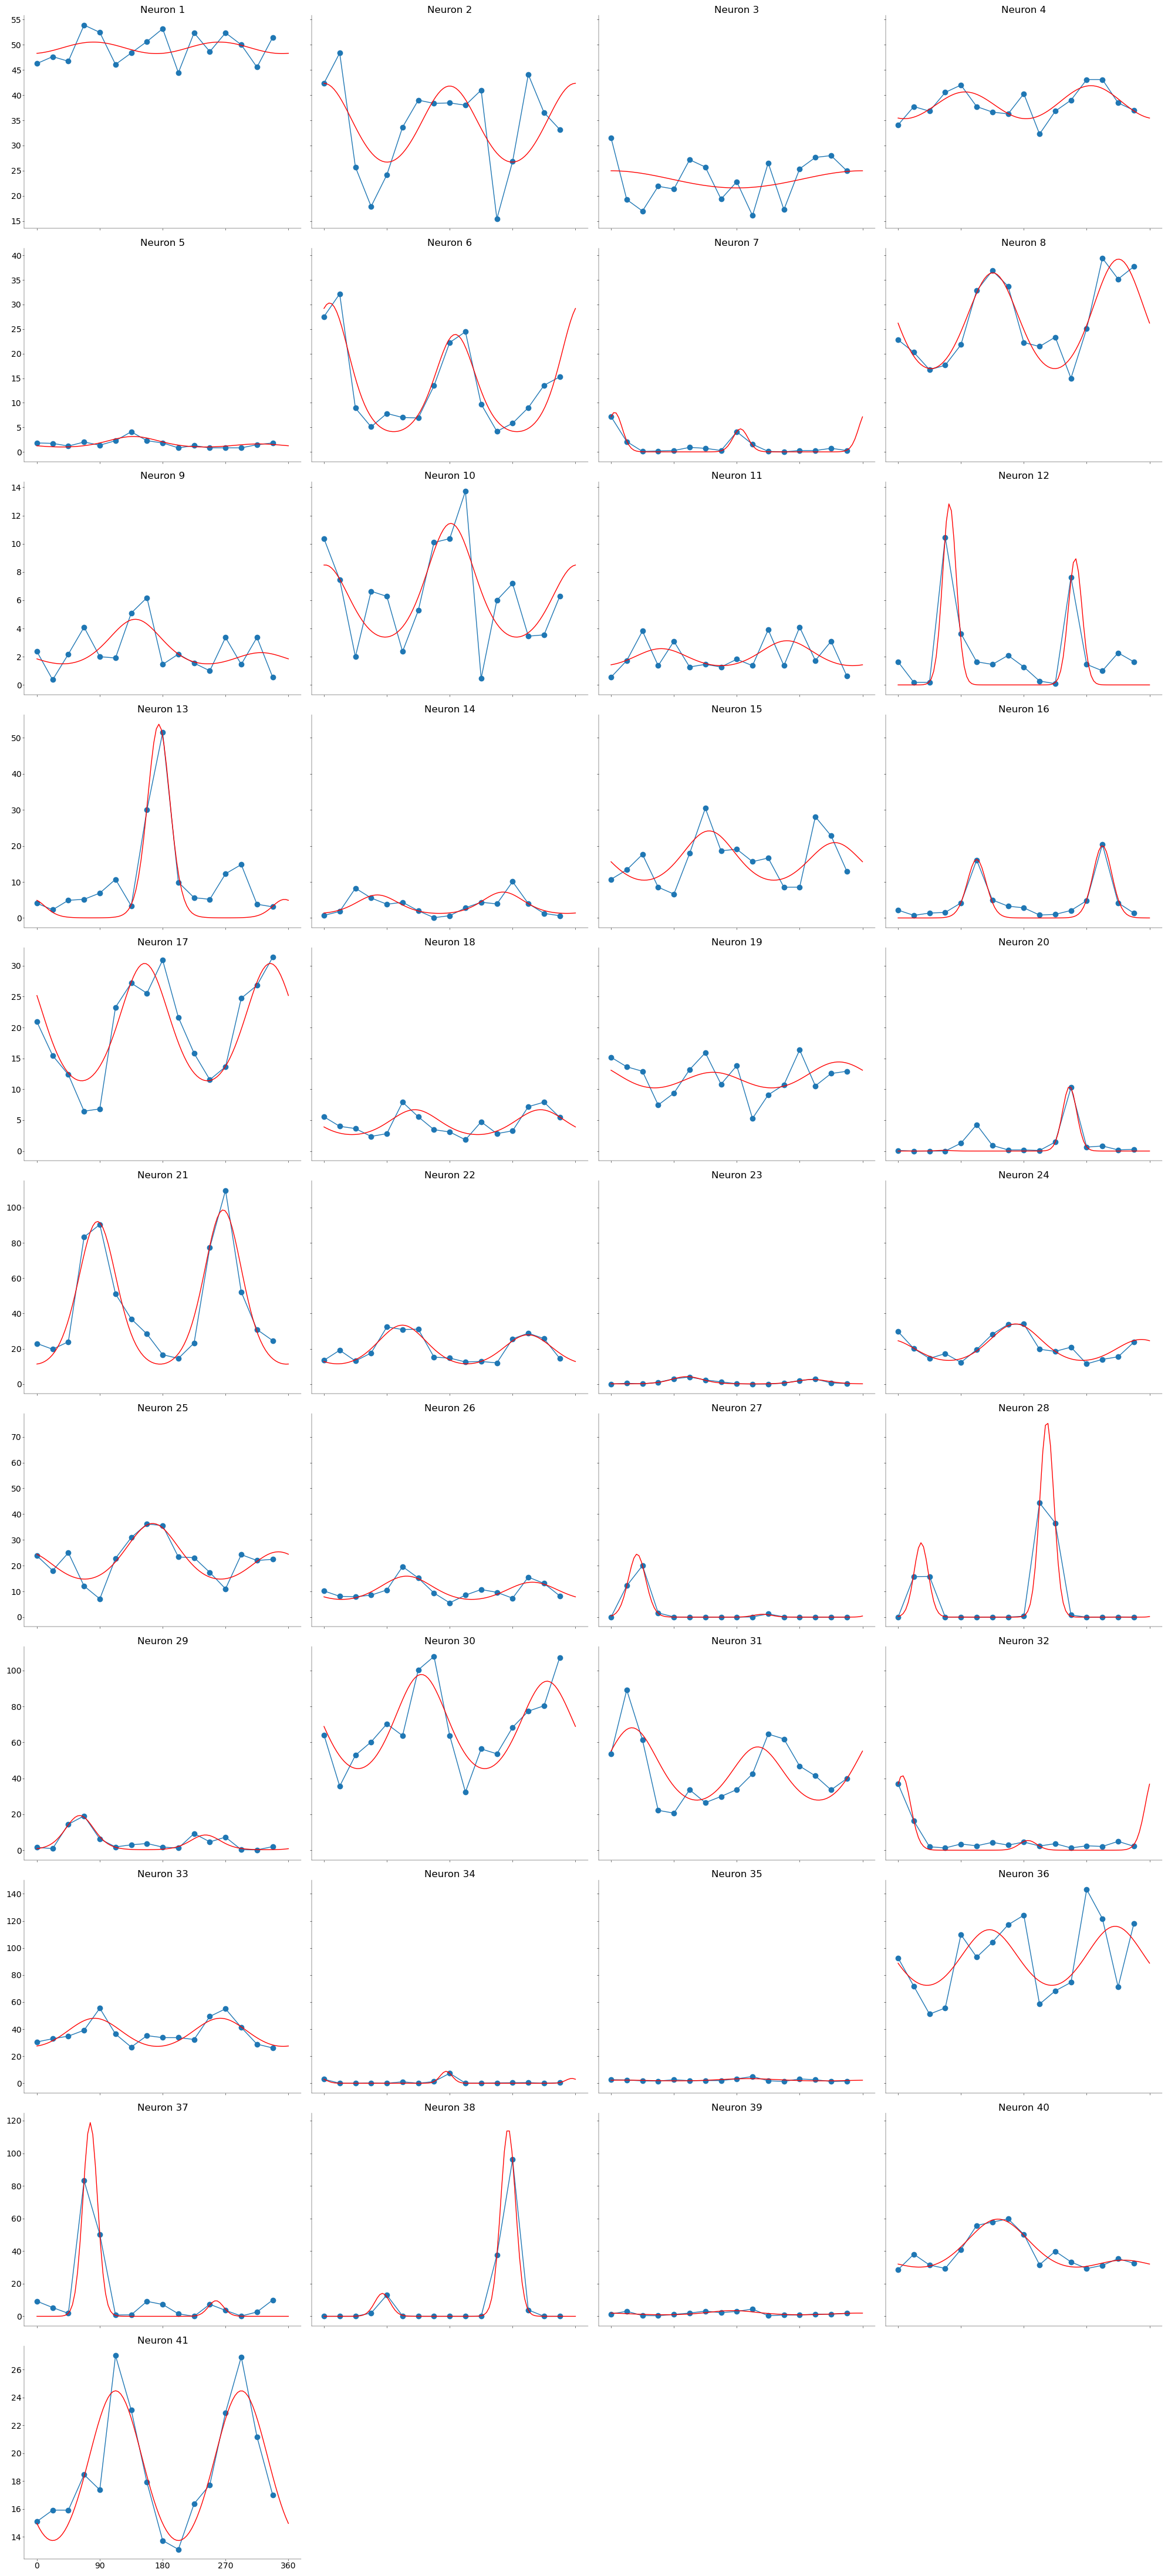

In [168]:
all_neuron_ids = spikes["Neuron"].unique()  # Or a subset you want to plot
num_neurons = len(all_neuron_ids)
ncols = 4  # Example: 4 plots per row
nrows = int(np.ceil(num_neurons / ncols))

fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 5, nrows * 4), sharex=True, sharey="row"
)  # Adjust sharey as needed
axes = axes.flatten()  # To easily iterate through axes


for i, neuron_id in enumerate(all_neuron_ids):
    if i >= len(axes):  # Stop if we run out of subplots
        break
    ax = axes[i]
    dirs_sorted, counts_sorted = get_data(spikes, neuron_id)

    # Get fit parameters *without* showing individual plot
    p_opt = None
    r_sq = None
    try:
        p_opt = tuningCurve(counts_sorted, dirs_sorted, neuron_id=neuron_id, show=False)
    except Exception as e:
        logger.warning(f"Error fitting tuning curve for neuron {neuron_id}: {e}")
        p_opt = None
    # You'd also need mean_counts_to_fit and unique_stim_directions_deg here
    spike_count_matrix_x = compute_spike_count_matrix(counts_sorted, dirs_sorted)
    mean_counts_to_fit = np.mean(spike_count_matrix_x, axis=0)
    unique_stim_directions_deg = np.unique(dirs_sorted)

    ax.plot(unique_stim_directions_deg, mean_counts_to_fit, "o-")
    if p_opt is not None:
        theta_plot_deg = np.linspace(0, 360, 100)
        fitted_values = vonMises(np.deg2rad(theta_plot_deg), *p_opt)
        ax.plot(theta_plot_deg, fitted_values, "r-")
    ax.set_title(f"Neuron {neuron_id}")
    ax.set_xticks(np.arange(0, 361, 90))  # Fewer ticks for subplots

# Hide any unused subplots
for j in range(i + 1, nrows * ncols):
    if j < len(axes):  # Check if axes[j] exists
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [169]:
def compute_null_distribution(
    counts: np.ndarray,
    dirs: np.ndarray,
    v_k: np.ndarray,
    niters: int,
    rng: np.random.Generator,
) -> np.ndarray:
    """Compute the null distribution of |q| under the null hypothesis.

    Parameters
    ----------
    counts: np.ndarray
        The spike counts for each trial.

    dirs: np.ndarray
        The stimulus directions for each trial.

    v_k: np.ndarray
        The complex exponential vector for the specified psi.

    niters: int
        Number of iterations for the permutation test.

    rng: np.random.Generator
        Random number generator for reproducibility.
    Returns
    -------
    q_distribution_null: np.ndarray
        The computed null distribution of |q|.

    """
    # Initialize an array to store the |q| values from each permutation
    q_distribution_null = np.zeros(niters)
    logger.info(f"Starting permutation test with {niters} iterations...")

    # Loop over the number of iterations
    for i in range(niters):
        # 1. Permute the data: Shuffle the spike counts randomly across all trials.
        shuffled_trial_counts = rng.permutation(counts)

        # 2. Recalculate m_k (average spike count per direction) for this permuted dataset.
        permuted_spike_matrix = compute_spike_count_matrix(shuffled_trial_counts, dirs)
        m_k_permuted = np.mean(permuted_spike_matrix, axis=0)

        # 3. Recalculate |q| using the permuted m_k_permuted and the *original* v_k.
        # v_k does not change because it depends on the stimulus directions and psi,
        # which are fixed.
        q_complex_permuted = np.dot(m_k_permuted, v_k)
        q_magnitude_permuted = np.abs(q_complex_permuted)

        # 4. Store the magnitude from this permutation.
        q_distribution_null[i] = q_magnitude_permuted

        if (i + 1) % (niters // 10) == 0:  # Log progress every 10%
            logger.debug(f"Permutation iteration {i+1}/{niters} completed.")

    logger.info("Permutation test finished.")

    return q_distribution_null

In [170]:
def plot_null_distribution(
    q_distribution_null: np.ndarray,
    q_observed_magnitude: float,
    niters: int,
    title: str = "Null Distribution of |q|",
):
    """Plot the null distribution of |q| and the observed |q|.

    Parameters
    ----------
    q_distribution_null: np.ndarray
        The computed null distribution of |q|.

    q_observed_magnitude: float
        The observed magnitude of |q| from the original data.

    niters: int
        Number of iterations for the permutation test.
    """
    plt.figure(figsize=(8, 6))

    # Plot the histogram of the null distribution
    plt.hist(
        q_distribution_null,
        bins=50,
        density=True,
        alpha=0.7,
        color="skyblue",
        label=f"Null Distribution of |q|\n({niters} permutations)",
    )

    # Add a vertical line for the observed |q|
    plt.axvline(
        x=q_observed_magnitude,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Observed |q| = {q_observed_magnitude:.4f}",
    )

    plt.title(title)
    plt.xlabel("|q|")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()

In [171]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
    neuron: int = None,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """
    # -------------------------------
    # Calculate m, nu and q (0.5 pts)
    # -------------------------------
    # m - This is the vector of average spike counts for each unique stimulus direction.
    spike_count_matrix = compute_spike_count_matrix(
        counts, dirs
    )  # 'counts' and 'dirs' are 1D arrays of all trials
    m_k = np.mean(spike_count_matrix, axis=0)  # Shape: (nUniqueDirs,)

    # Get unique directions and convert to radians for v_k
    unique_stim_directions_deg = np.unique(
        dirs
    )  # These are the directions corresponding to columns of spike_count_matrix
    theta_k_rad = np.deg2rad(unique_stim_directions_deg)  # Shape: (nUniqueDirs,)

    # v_k - This is the complex exponential vector for the specified psi.
    # It should be based on the unique radian directions theta_k_rad.
    v_k = np.exp(1j * psi * theta_k_rad)  # Corrected: Shape: (nUniqueDirs,)

    # q - This is the projection of m_k onto v_k.
    q_complex_observed = np.dot(m_k, v_k)

    # Magnitude of the projection for the observed data.
    # This is the 'q' to be returned and tested against null distribution.
    q_observed_magnitude = np.abs(q_complex_observed)

    logger.debug(f"Observed q magnitude: {q_observed_magnitude}")
    logger.debug(f"Observed q complex: {q_complex_observed}")
    logger.debug(f"Observed m_k: {m_k}")
    logger.debug(f"Observed v_k: {v_k}")

    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    # Ensure reproducibility using a random number generator
    # Hint: Access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # 1-4. Compute the null distribution of |q| under the null hypothesis
    #    by running niters iterations where you repeat the same calculation as above
    #    but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x).
    #    This is done in the compute_null_distribution function.
    #    The q_distribution_null is the array of |q| values from the null distribution.
    #    The function compute_null_distribution is defined above.
    #    It takes the counts, dirs, v_k, niters, and rng as inputs.
    q_distribution_null = compute_null_distribution(
        counts=counts, dirs=dirs, v_k=v_k, niters=niters, rng=rng
    )

    # 5. Calculate the p-value.
    #    This is the proportion of permuted |q| values that are as extreme as,
    #    or more extreme than, the |q| observed from the original data.
    # We use smoothing to avoid p-values of 0 or 1.
    p_value = (np.sum(q_distribution_null >= q_observed_magnitude) + 1) / (niters + 1)
    # p_value = np.sum(q_distribution_null >= q_observed_magnitude) / niters

    # For a slightly more robust p-value, especially if niters is not huge or q_observed_magnitude is very extreme:
    # p_value_corrected = (np.sum(q_distribution_null >= q_observed_magnitude) + 1) / (niters + 1)
    # You can choose which one to use; the simpler one is fine for this lab typically.
    logger.info(
        f"Observed |q|: {q_observed_magnitude:.4f}, Calculated p-value: {p_value:.35f}"
    )

    if show:
        neuron_title_str = "" if neuron is None else f"Neuron: {neuron}"
        title = f"Null Distribution {neuron_title_str} $\Psi$ : {psi}  P Value: {p_value:.05f}"
        plot_null_distribution(
            q_distribution_null, q_observed_magnitude, niters, title=title
        )
    # The array q_distribution_null is the 'qdistr' to be returned.
    qdistr = q_distribution_null
    return p_value, q_observed_magnitude, qdistr

In [172]:
def test_neuron_tuning(all_neuron_ids, spikes, niters=1000):
    """Test the tuning of a neuron for direction and orientation."""
    tuning_results = []

    for i, neuron_id in enumerate(all_neuron_ids):
        logger.info(f"Processing neuron {i+1}/{len(all_neuron_ids)}: ID {neuron_id}...")

        # Get data for the current neuron
        dirs_sorted, counts_sorted = get_data(spikes, neuron_id)

        # It's possible some neurons might have no spikes in the defined periods.
        # get_data should produce empty or all-zero counts_sorted in such cases.
        # testTuning should ideally handle this (e.g., result in a non-significant p-value).
        # For instance, if all counts are 0, m_k will be 0, q_observed_magnitude will be 0,
        # and p_value will likely be 1.0, which is correct (not selective).

        # Test for direction tuning (psi=1)
        p_direction, q_direction, _ = testTuning(
            counts_sorted,
            dirs_sorted,
            psi=1,
            niters=niters,
            show=False,  # No plots for batch processing
            neuron=neuron_id,  # Pass neuron ID for logging
        )

        # Test for orientation tuning (psi=2)
        p_orientation, q_orientation, _ = testTuning(
            counts_sorted,
            dirs_sorted,
            psi=2,
            niters=niters,
            show=False,
            neuron=neuron_id,  # Pass neuron ID for logging
        )

        tuning_results.append(
            {
                "neuron_id": neuron_id,
                "p_direction": p_direction,
                "q_direction": q_direction,
                "p_orientation": p_orientation,
                "q_orientation": q_orientation,
            }
        )

    return pd.DataFrame(tuning_results)

In [173]:
def filter_tuning_results(tuning_results_df, alpha_threshold=0.01):
    """Filter the tuning results based on the significance level."""
    logging.debug(f"\n--- Tuning Selectivity Results (p < {alpha_threshold}) ---")

    direction_selective_neurons = tuning_results_df[
        tuning_results_df["p_direction"] < alpha_threshold
    ]
    orientation_selective_neurons = tuning_results_df[
        tuning_results_df["p_orientation"] < alpha_threshold
    ]

    logging.debug(f"\nDirection Selective Neurons (psi=1, p < {alpha_threshold}):")
    if not direction_selective_neurons.empty:
        logging.debug(
            direction_selective_neurons[["neuron_id", "p_direction", "q_direction"]]
        )
    else:
        logging.debug(
            "No neurons found to be significantly direction selective at this threshold."
        )

    logging.debug(f"\nOrientation Selective Neurons (psi=2, p < {alpha_threshold}):")
    if not orientation_selective_neurons.empty:
        logging.debug(
            orientation_selective_neurons[
                ["neuron_id", "p_orientation", "q_orientation"]
            ]
        )
    else:
        logging.debug(
            "No neurons found to be significantly orientation selective at this threshold."
        )

    # You might also be interested in neurons that are BOTH or EXCLUSIVELY one type
    both_selective = tuning_results_df[
        (tuning_results_df["p_direction"] < alpha_threshold)
        & (tuning_results_df["p_orientation"] < alpha_threshold)
    ]
    logging.debug(
        f"\nNeurons Selective for BOTH Direction and Orientation (p < {alpha_threshold}):"
    )
    if not both_selective.empty:
        logging.debug(both_selective[["neuron_id", "p_direction", "p_orientation"]])
    else:
        logging.debug(
            "No neurons found to be significantly selective for both at this threshold."
        )

    # Example: Strictly direction selective (significant for direction, not for orientation)
    strictly_direction_selective = tuning_results_df[
        (tuning_results_df["p_direction"] < alpha_threshold)
        & (tuning_results_df["p_orientation"] >= alpha_threshold)
    ]
    logging.debug(
        f"\nNeurons Strictly Direction Selective (p_dir < {alpha_threshold}, p_ori >= {alpha_threshold}):"
    )
    if not strictly_direction_selective.empty:
        logging.debug(
            strictly_direction_selective[["neuron_id", "p_direction", "p_orientation"]]
        )
    else:
        logging.debug(
            "No neurons found to be strictly direction selective at this threshold."
        )
    return (
        direction_selective_neurons,
        orientation_selective_neurons,
        both_selective,
        strictly_direction_selective,
    )

Show null distribution for the example cell:

INFO:__main__:Fitting tuning curve...
INFO:__main__:Counts: (176,)
INFO:__main__:Dirs: (176,)
INFO:__main__:Spike count matrix shape: (11, 16)
INFO:__main__:Spike count matrix: [[ 0. 16. 13.  0.  0.  0.  0.  0.  0. 48. 26.  3.  0.  0.  1.  0.]
 [ 0.  9. 29.  0.  1.  0.  0.  0.  0. 44. 41.  1.  0.  0.  0.  0.]
 [ 0. 25. 17.  0.  0.  0.  0.  0.  0. 45. 30.  2.  0.  0.  0.  0.]
 [ 0. 15.  3.  0.  0.  0.  0.  0.  0. 44. 40.  2.  0.  0.  0.  0.]
 [ 0. 19. 24.  0.  0.  0.  0.  0.  3. 43. 55.  1.  0.  0.  0.  0.]
 [ 0. 10. 15.  0.  0.  0.  0.  0.  1. 52. 32.  0.  0.  0.  0.  0.]
 [ 0. 11. 14.  0.  0.  0.  0.  0.  0. 37. 42.  0.  0.  0.  0.  0.]
 [ 0. 14. 16.  0.  0.  0.  0.  0.  0. 48. 19.  0.  0.  0.  0.  0.]
 [ 0. 20. 16.  0.  0.  0.  0.  0.  0. 32. 39.  0.  0.  0.  0.  0.]
 [ 0. 10. 13.  0.  0.  0.  0.  0.  0. 54. 47.  0.  0.  0.  0.  0.]
 [ 0. 24. 14.  0.  0.  0.  0.  0.  0. 41. 31.  0.  0.  0.  0.  0.]]
INFO:__main__:Mean counts to fit: [ 0.         15.72727273 15.81818182  0.          0

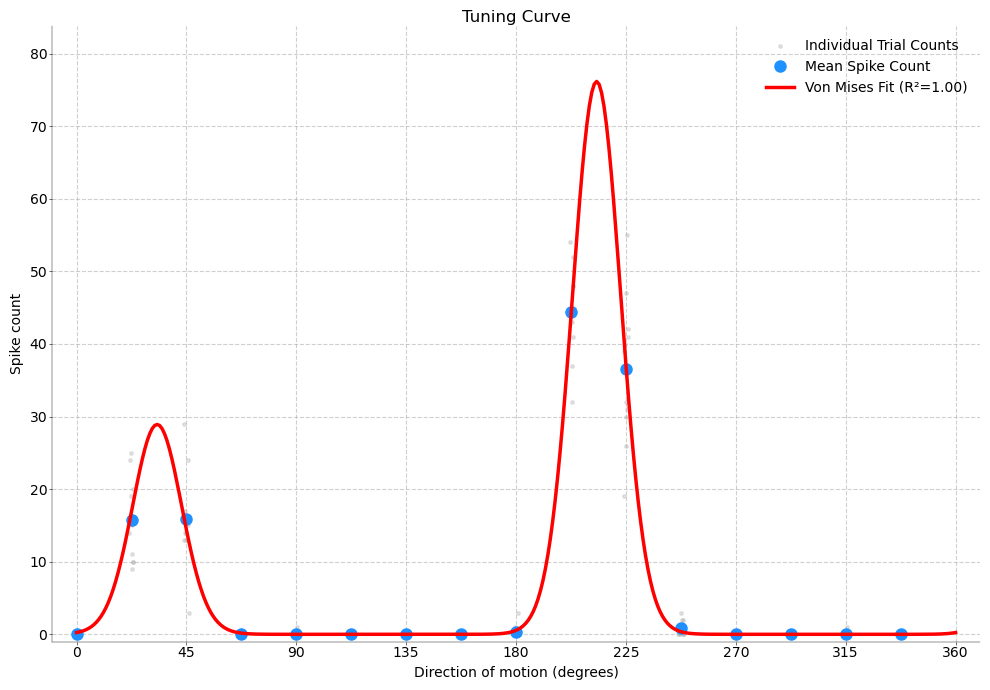

INFO:__main__:Starting permutation test with 1000 iterations...
INFO:__main__:Permutation test finished.
INFO:__main__:Observed |q|: 49.3461, Calculated p-value: 0.00099900099900099900013250575625534


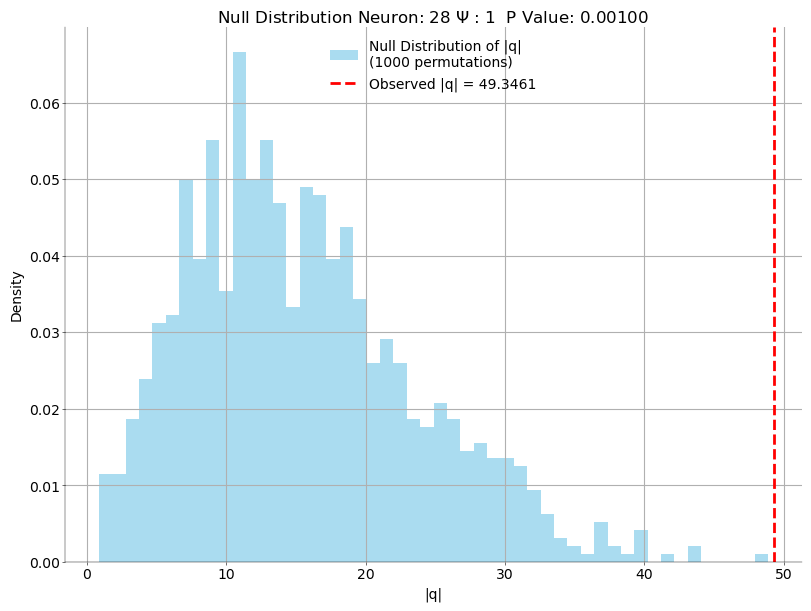

INFO:__main__:Neuron:28 psi == 1 ->  p-value: 0.000999000999000999, q_observed_magnitude: 49.346055054629936
INFO:__main__:Starting permutation test with 1000 iterations...
INFO:__main__:Permutation test finished.
INFO:__main__:Observed |q|: 104.2576, Calculated p-value: 0.00099900099900099900013250575625534


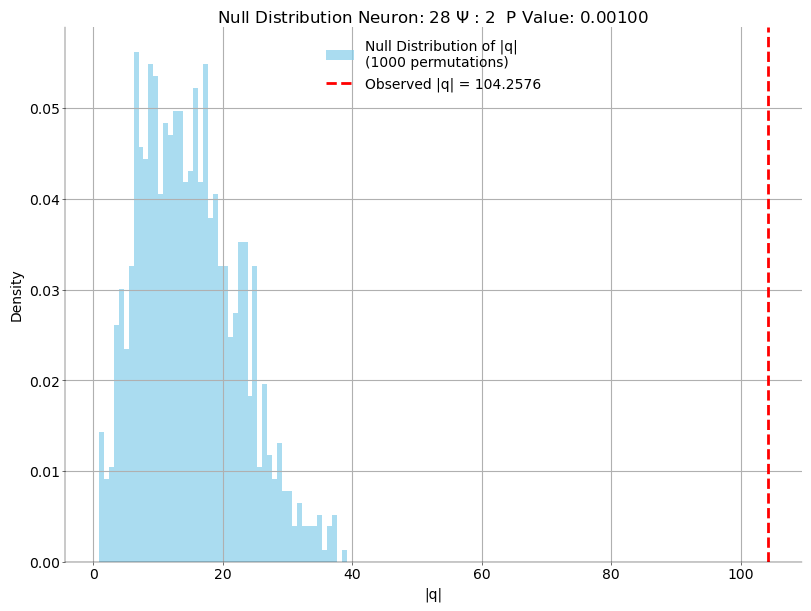

INFO:__main__:Neuron:28 psi == 2 ->  p-value: 0.000999000999000999, q_observed_magnitude: 104.25762657685993
INFO:__main__:Fitting tuning curve...
INFO:__main__:Counts: (176,)
INFO:__main__:Dirs: (176,)
INFO:__main__:Spike count matrix shape: (11, 16)
INFO:__main__:Spike count matrix: [[ 5.  1. 15. 19.  9.  2.  4.  4.  3.  3.  5.  4.  3.  1.  1.  6.]
 [ 6.  4. 14. 13.  3.  2.  3.  9.  0.  1.  6. 11.  6.  0.  0.  2.]
 [ 3.  1. 14. 20.  3.  2.  0.  3.  0.  0.  1.  7. 20.  0.  0.  1.]
 [ 2.  2. 26. 19. 13.  4.  0.  1.  2.  1.  7.  8.  5.  0.  0.  4.]
 [ 1.  2.  1. 23.  8.  1.  5.  2.  3.  8. 16.  6. 15.  0.  0.  6.]
 [ 0.  0. 10. 27.  3.  1.  0.  3.  3.  0.  9.  4.  7.  0.  1.  2.]
 [ 0.  0.  4. 16. 11.  3.  4.  2.  4.  0.  6.  3.  5.  0.  0.  1.]
 [ 0.  0. 28. 25.  5.  2.  1.  5.  4.  0. 11.  7.  4.  0.  0.  0.]
 [ 0.  0. 19. 24.  5.  1. 10.  1.  0.  0.  1.  0.  7.  0.  0.  0.]
 [ 0.  0.  9. 12.  2.  0.  5.  8.  0.  0. 16.  0.  6.  1.  0.  0.]
 [ 0.  0. 19. 12.  7.  2.  1.  3.  0.  0. 24

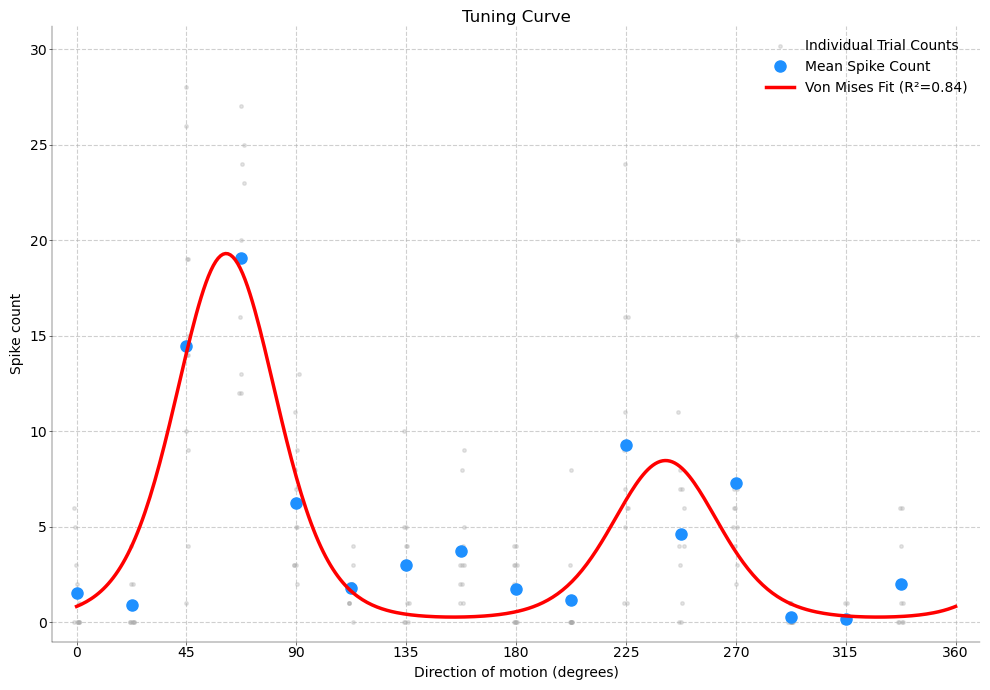

INFO:__main__:Starting permutation test with 1000 iterations...
INFO:__main__:Permutation test finished.
INFO:__main__:Observed |q|: 20.5138, Calculated p-value: 0.00299700299700299700039751726876602


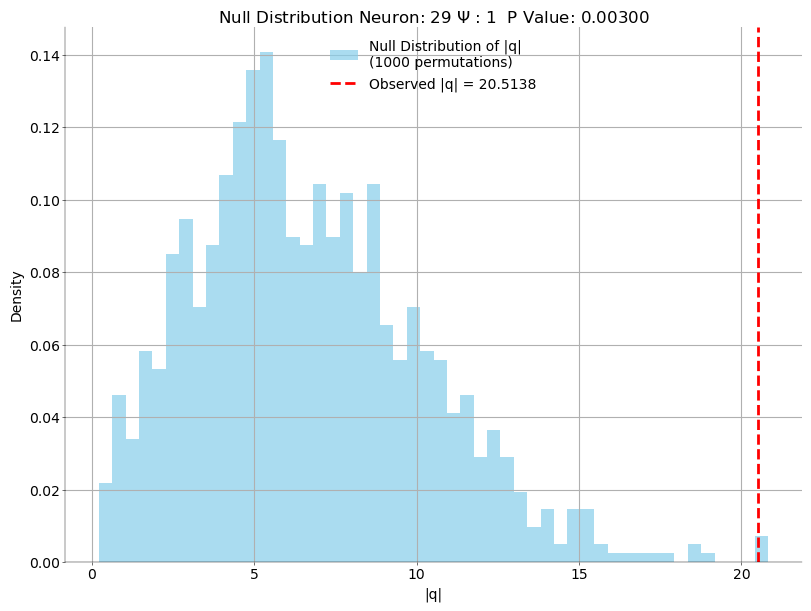

INFO:__main__:Neuron:29 psi == 1 ->  p-value: 0.002997002997002997, q_observed_magnitude: 20.513794410681133
INFO:__main__:Starting permutation test with 1000 iterations...
INFO:__main__:Permutation test finished.
INFO:__main__:Observed |q|: 40.4493, Calculated p-value: 0.00099900099900099900013250575625534


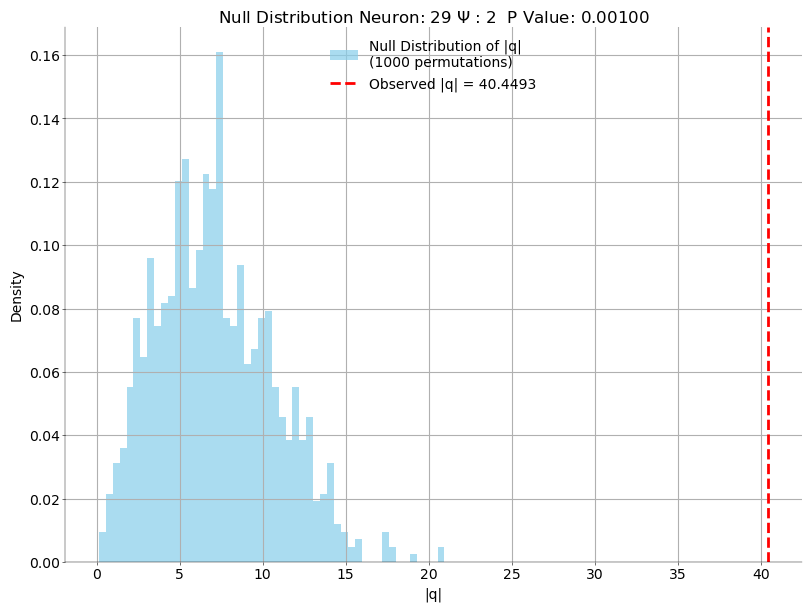

INFO:__main__:Neuron:29 psi == 2 ->  p-value: 0.000999000999000999, q_observed_magnitude: 40.44931965569163


In [174]:
# ---------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (1 pt)
# ---------------------------------------------------------
neurons_to_plot = [28, 29]
for neuron in neurons_to_plot:
    dirs_sorted, counts_sorted = get_data(spikes, neuron)
    result = tuningCurve(counts_sorted, dirs_sorted, show=True)
    for psi in [1, 2]:
        p_value, q_observed_magnitude, qdistr = testTuning(
            counts_sorted, dirs_sorted, psi=psi, show=True, niters=1000, neuron=neuron
        )
        logger.info(
            f"Neuron:{neuron} psi == {psi} ->  p-value: {p_value}, q_observed_magnitude: {q_observed_magnitude}"
        )

Test all cells for orientation and direction tuning

In [175]:
# --------------------------------------------------
# Test all cells for orientation / direction tuning.
# Which ones are selective? (0.5 pts)
# --------------------------------------------------
# %%
neuron_tuning_results_df = test_neuron_tuning(
    np.unique(spikes["Neuron"]), spikes, niters=1000
)
# %% Filter the results based on the significance level
(
    direction_selective_neurons,
    orientation_selective_neurons,
    both_selective,
    strictly_direction_selective,
) = filter_tuning_results(neuron_tuning_results_df, alpha_threshold=0.01)

INFO:__main__:Processing neuron 1/41: ID 1...
INFO:__main__:Starting permutation test with 1000 iterations...
INFO:__main__:Permutation test finished.
INFO:__main__:Observed |q|: 5.6842, Calculated p-value: 0.87112887112887116281001453899079934
INFO:__main__:Starting permutation test with 1000 iterations...
INFO:__main__:Permutation test finished.
INFO:__main__:Observed |q|: 8.9238, Calculated p-value: 0.69930069930069926886773146179621108
INFO:__main__:Processing neuron 2/41: ID 2...
INFO:__main__:Starting permutation test with 1000 iterations...
INFO:__main__:Permutation test finished.
INFO:__main__:Observed |q|: 13.1883, Calculated p-value: 0.48451548451548454021775569344754331
INFO:__main__:Starting permutation test with 1000 iterations...
INFO:__main__:Permutation test finished.
INFO:__main__:Observed |q|: 69.5850, Calculated p-value: 0.00099900099900099900013250575625534
INFO:__main__:Processing neuron 3/41: ID 3...
INFO:__main__:Starting permutation test with 1000 iterations...


In [176]:
num_direction_tuned = len(direction_selective_neurons)
num_orientation_tuned = len(orientation_selective_neurons)
num_both_tuned = len(both_selective)  # 'both_selective' from your filter_tuning_results

total_unique_tuned_cells = num_direction_tuned + num_orientation_tuned - num_both_tuned

print(
    f"Total number of unique neurons showing any tuning (direction or orientation, p < 0.01): {total_unique_tuned_cells}"
)

Total number of unique neurons showing any tuning (direction or orientation, p < 0.01): 34


Number of direction tuned neurons:

In [177]:
print(f"Number of direction selective neurons: {len(direction_selective_neurons)}")

Number of direction selective neurons: 12


Number of orientation tuned neurons:

In [178]:
print(f"Number of orientation selective neurons: {len(orientation_selective_neurons)}")

Number of orientation selective neurons: 34


In [ ]:
print(f"Number of neurons selective for both: {len(both_selective)}")
print(
    f"Number of strictly direction selective neurons: {len(strictly_direction_selective)}"
)

Number of neurons selective for both: 12
Number of strictly direction selective neurons: 0
